# [IAPR][iapr]: Lab 3 ‒  Classification


**Group ID:** 14

**Author 1 (sciper):** Emna Tourki (288580)
**Author 2 (sciper):** Yu-Hsin Yang (334949)   
**Author 3 (sciper):** Tabea Steinbrinker (350566) 

**Release date:** 07.04.2022
**Due date:** 29.04.2022


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

In [1]:
# !pip install torch
# !pip install torchvision

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.

**Note**: we can load Matlab files using the [scipy.io] module.

[scipy.io]: https://docs.scipy.org/doc/scipy/reference/io.html

In [3]:
import scipy.io

data_part1_path = os.path.join(data_base_path, data_folder, 'part1', 'classification.mat')
matfile = scipy.io.loadmat(data_part1_path)
a = matfile['a']
b = matfile['b']
c = matfile['c']

print(a.shape, b.shape, c.shape)

(200, 2) (200, 2) (200, 2)


### 1.1 Bayes method (5 pts)
Using the Bayes method, give the expression of the separation curves between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data. Note that you do not need to solve the analytical expression. You can simply evaluate the function for each point on the plane to end up with a segmentation map.
For simplicity reasons, round the estimated parameters to the closest integer value.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# for visualization, plot the points in a scatterplot
means = np.empty((3,2))
var = np.empty((3,2,2))
for i, x in enumerate([a,b,c]):
    means[i] = np.array([round(np.mean(x, axis = 0)[0]),round(np.mean(x, axis = 0)[1])])
    var[i] = np.around(np.cov(x[:,0],x[:,1]))

In [6]:
# Add your implementation and discussion

def g(x, mu, sigma, P):
    sigma_inv = np.linalg.inv(sigma)
    res = - 1/2 * (x-mu).T @ sigma_inv @ (x-mu)
    res += np.log(P)
    res += -np.log(np.sqrt(2*np.pi*np.linalg.det(sigma)))
    return res

In [7]:
x_plane = np.linspace(-13,15,num = 501)
y_plane = np.linspace(-6,6, num = 501)
boundab_x = []
boundab_y = []

boundac_x = []
boundac_y = []

boundbc_x = []
boundbc_y = []


tol = 0.1

for x in x_plane:
    for y in y_plane:
        point = np.array([x,y])
        a_val = g(point,means[0],var[0],1/3)
        b_val = g(point,means[1],var[1],1/3)
        c_val = g(point,means[2],var[2],1/3)
        if abs(a_val - b_val) < tol:
            boundab_x.append(point[0])
            boundab_y.append(point[1])

        if abs(a_val - c_val) < tol:
            boundac_x.append(point[0])
            boundac_y.append(point[1])

        if abs(b_val - c_val) < tol:
            boundbc_x.append(point[0])
            boundbc_y.append(point[1])

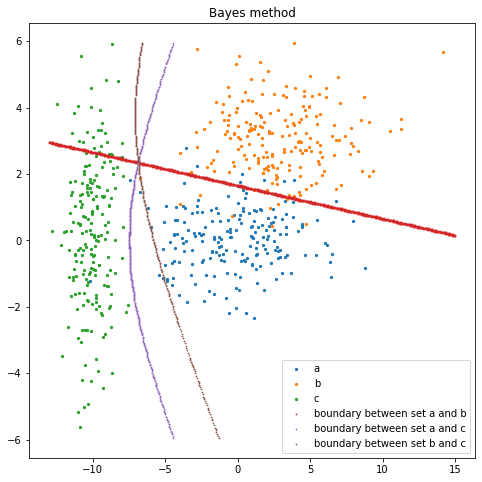

In [8]:
names = ['a','b','c']

fig = plt.figure(figsize = (8,8))
for i, x in enumerate([a,b,c]):
    plt.scatter(x[:,0],x[:,1], label = names[i], s =5)
    #plt.scatter(np.mean(x, axis = 0)[0],np.mean(x, axis = 0)[1], marker = 'x', linewidth = 3)
plt.scatter(boundab_x, boundab_y, s = 0.5, label = 'boundary between set a and b')
plt.scatter(boundac_x, boundac_y, s = 0.5, label = 'boundary between set a and c')
plt.scatter(boundbc_x, boundbc_y, s = 0.5, label = 'boundary between set b and c')
plt.title('Bayes method')
plt.legend()
plt.show()

### 1.2 Mahalanobis distance (5 pts)
For classes `a` and `b`, give the expression of the Mahalanobis distance used to classify a point in class `a` or `b`, and verify the obtained classification, in comparison with the "complete" Bayes classification, for a few points of the plane.

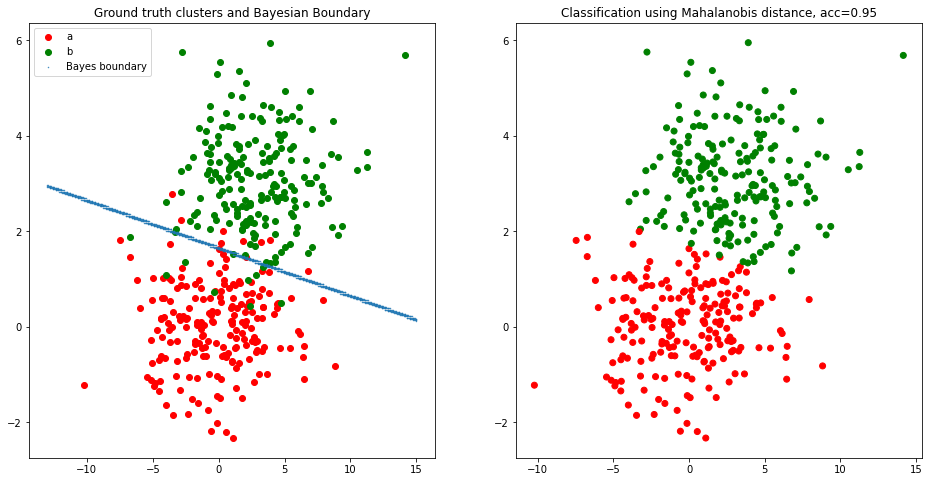

Classification using Mahalanobis distance, accuracy=0.95


In [9]:
# Add your implementation and discussion
from scipy.spatial import distance
import scipy

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].set_title("Ground truth clusters and Bayesian Boundary")
ax[0].scatter(a[:,0],a[:,1],label='a', color = 'r' )
ax[0].scatter(b[:,0],b[:,1],label='b', color = 'g')
ax[0].scatter(boundab_x, boundab_y, s = 0.2, label = 'Bayes boundary')
ax[0].legend()

N_CLUSTER=2
_N=200
mu_a=np.mean(a, axis=0)
mu_b=np.mean(b, axis=0)
cov_a=np.cov(a.T)
# the rounded covariance matrix is the same for a and b so we can take either one
rounded_cov=np.rint(cov_a)
npMEANS  = np.array([mu_a,mu_b])
colors   = np.array(["red","green"])
legends = np.array(["a","b"])

npX=np.concatenate((a,b),axis=0)

npMAHALANOBIS = [[0 for _ in range(N_CLUSTER)] for _ in range(npX.shape[0])]

for isample in range(npX.shape[0]):
    for icluster in range(N_CLUSTER):
        #Calculate the Mahalanobis distance for each point to each of the two clusters' mean
        npMAHALANOBIS[isample][icluster] = distance.mahalanobis(npX[isample],npMEANS[icluster],
                                                                VI=scipy.linalg.pinv(rounded_cov))
npMAHALANOBIS = np.array(npMAHALANOBIS)

#Ground truth
GT = [0 for _ in range(_N)] + [1 for _ in range(_N)]
# For each point, the predicted class is the one that has the lowest Mahalanobis distance
pred = npMAHALANOBIS.argmin(axis=1)

ax[1].scatter(npX[:,0],npX[:,1],c=colors[pred],label=legends[pred])
ax[1].set_title("Classification using Mahalanobis distance, acc={:3.2f}".format(np.mean(GT == pred)))
plt.show()
print("Classification using Mahalanobis distance, accuracy={:3.2f}".format(np.mean(GT == pred)))

To do the classification based on the Mahalanobis distance we need the two means and their covariance matrix.  
When rounded the covariance matrix is the same for the two classes a an b.  
We calculated the Mahalanobis distance for each point to each of the two clusters' mean.  
$d_m = ((x-\mu_i)^T \Sigma^{-1}(x-\mu_i))^{1/2}$  
Then the most probable class is the one that minimizes that Mahalanobis distance.  
We found an accuracy of 0.95  
As for the comparison between the Bayes classification and the Classification using Mahalanobis, we can see in the plots above that both classifications give approximately the same result.There is only one or two points near the Bayesian boundary with different classification.The accuracy of the Bayes classification is also 0.95 (20 misclassified points out of 400).  

---

## Part 2
In this part, we aim to classify digits using the complete version of MNIST digits dataset.
The dataset consists of 60'000 training images and 10'000 test images of handwritten digits.
Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value.
Given this data, your task is to construct a Multilayer Perceptron (MLP) for supervised training and classification and evaluate it on the test images.

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under `lab-03-data/part2`.
You can then use the script provided below to extract and load training and testing images in Python. 

**! Warning**: When the lab was created the official MNIST repo was down, if it is still the case please use https://github.com/mkolod/MNIST.

### 2.1 Dataset loading
Here we first declare the methods `extract_data` and `extract_labels` so that we can reuse them later in the code.
Then we extract both the data and corresponding labels, and plot randomly some images and corresponding labels of the training set.

In [10]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [11]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

print(type(train_labels))

<class 'numpy.ndarray'>


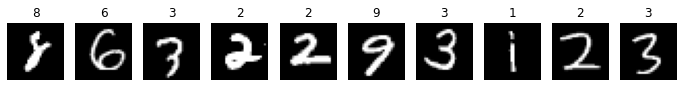

In [12]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

### 2.2 MLP (10 pts)

To create an MLP you are free to choose any library.
In case you don't have any preferences, we encourage you to use the [scikit-learn] package; it is a simple, efficient and free tool for data analysis and machine learning.
In this [link][sklearn-example], you can find a basic example to see how to create and train an MLP using [scikit-learn].
Your network should have the following properties:
* Input `x`: 784-dimensional (i.e. 784 visible units representing the flattened 28x28 pixel images).
* 100 hidden units `h`.
* 10 output units `y`, i.e. the labels, with a value close to one in the i-th class representing a high probability of the input representing the digit `i`.

If you need additional examples you can borrow some code from image classification tutorials.
However, we recommend that you construct a minimal version of the network on your own to gain better insights.

[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

In [13]:
# Implementing using sklearn
# Preprocessing on images

# Reshape the image into 28*28 = 784
train_feature_vector = train_images.reshape(len(train_images), 784).astype('float32')
test_feature_vector = test_images.reshape(len(test_images), 784).astype('float32')


# Normalize the images 
train_feature_norm = train_feature_vector/255
test_feature_norm = test_feature_vector/255

In [14]:
# Preprocessing on label -> One-Hot Encoding
from sklearn import preprocessing

ohe = preprocessing.OneHotEncoder()

train_labels_res = train_labels.reshape(-1, 1)
test_labels_res = test_labels.reshape(-1, 1)


ohe.fit(train_labels_res)
ohe_train_labels = ohe.transform(train_labels_res).toarray()
ohe_test_labels = ohe.transform(test_labels_res).toarray()

In [15]:
# Start Training (Multi-Layer Perceptron)
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

def MLP(solver, hidden_layer):
    
    if(hidden_layer == 1):
        layer_sizes = (100, )
    else:
        layer_sizes = (100, 100, )
        

    
    clf = MLPClassifier(solver=solver, alpha=1e-5, hidden_layer_sizes=layer_sizes, random_state=1,  max_iter=400)
    clf.fit(train_feature_norm, ohe_train_labels)
    
    predictions_train = clf.predict(train_feature_norm)
    predictions_test = clf.predict(test_feature_norm)
    train_score = accuracy_score(predictions_train, ohe_train_labels)
    print("Accuracy score on train data: ", train_score)
    test_score = accuracy_score(predictions_test, ohe_test_labels)
    print("Accuracy score on test data: ", test_score)

In [16]:
# solver = ‘lbfgs’, ‘sgd’, ‘adam’
# Here we choose 'adam' as our solver since it works pretty well - both training time and validation score - on relatively large datasets, i.e. thousands of training samples or more.
MLP('adam', 1)

Accuracy score on train data:  1.0
Accuracy score on test data:  0.9564


In [17]:
MLP('adam', 2)

Accuracy score on train data:  1.0
Accuracy score on test data:  0.9742


$

### Note
- According to the result, we can see that with more hidden layers, the accuracy score on both training and testing data increase. 